# Quantizing a `PyTorch` model

This notebook will try to quantize a pretraied VGG-16 model by following the recommended workflow that has been proposed by Nvidia in the paper [Integer Quantization for Deep Learning Inference: Principles and Empirical Evaluation](https://arxiv.org/abs/2004.09602)

meaning the the notebook will be divided into two sections

Section 1: before quantization evaluation

Section 2: after quantization evaluation which will be divided into three parts first post training quantization if that doesn't work sensitivity analysis will be conducted if that fails fine-tuning will be tried  

## Section 1: Evaluation

In [ ]:
try:
    import tensorrt as trt
except ModuleNotFoundError:
    !pip install tensorrt -q
    import tensorrt as trt


  Preparing metadata (setup.py) ... done


In [ ]:
try:
    import onnx
except ModuleNotFoundError:
    !pip install onnx -q
    import onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 44.8 MB/s eta 0:00:00


In [ ]:
try:
    import onnx_tensorrt.backend as backend

except ModuleNotFoundError:
    !git clone https://github.com/onnx/onnx-tensorrt.git
    !pip install pycuda
    %cd onnx-tensorrt
    !python3 setup.py install
    %cd ..
    import onnx_tensorrt.backend as backend


Cloning into 'onnx-tensorrt'...
remote: Enumerating objects: 1765, done.
remote: Counting objects: 100% (839/839), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 1765 (delta 713), reused 612 (delta 574), pack-reused 926
Receiving objects: 100% (1765/1765), 2.34 MiB | 7.22 MiB/s, done.
Resolving deltas: 100% (1223/1223), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.4 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661205 sha256=a6a1991858f2ce262690ec0074b27d4f6618cac72a8c5c846f07072d0ff038e2
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
S

ModuleNotFoundError: No module named 'onnx_tensorrt'

In [1]:
try:
    import timm
except ModuleNotFoundError:
    !pip install timm --quiet
    import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.5 MB/s eta 0:00:00


In [2]:
!mkdir data
!unzip /content/drive/MyDrive/Bustati/potato.zip -d data

Archive:  /content/drive/MyDrive/Bustati/potato.zip
   creating: data/train/
   creating: data/train/bone/
  inflating: data/train/bone/1436.png  
  inflating: data/train/bone/11677.png  
  inflating: data/train/bone/7883.png  
  inflating: data/train/bone/7295.png  
  inflating: data/train/bone/14109.png  
  inflating: data/train/bone/11574.png  
  inflating: data/train/bone/15107.png  
  inflating: data/train/bone/14285.png  
  inflating: data/train/bone/9157.png  
  inflating: data/train/bone/10960.png  
  inflating: data/train/bone/2373.png  
  inflating: data/train/bone/3567.png  
  inflating: data/train/bone/2298.png  
  inflating: data/train/bone/11539.png  
  inflating: data/train/bone/2819.png  
  inflating: data/train/bone/13546.png  
  inflating: data/train/bone/10685.png  
  inflating: data/train/bone/3654.png  
  inflating: data/train/bone/14712.png  
  inflating: data/train/bone/5273.png  
  inflating: data/train/bone/6981.png  
  inflating: data/train/bone/3343.png  
  i

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import torch
from torchvision import transforms

class ImageEncryption:
    """
    Class for image encryption using a combination of intra-block texture encryption
    and color encryption.

    Args:
        m (int): The number of subblocks in each dimension.

    Attributes:
        m (int): The number of subblocks in each dimension.

    Methods:
        image_encryption(image_path):
            Encrypts an image using intra-block texture encryption and color encryption.

        intrablock_texture_encryption(subblock):
            Encrypts a subblock using intra-block texture encryption.

        color_encryption(subblock, i):
            Encrypts a subblock using color encryption.
    """
    def __init__(self, m):
        """
        Initializes the ImageEncryption object.

        Args:
            m (int): The number of subblocks in each dimension.
        """
        self.m = m

    def image_encryption(self, image_path):
        """
        Encrypts an image using intra-block texture encryption and color encryption.

        Args:
            image_path (str): The path to the input image file.

        Returns:
            tuple: A tuple containing the encrypted image, image subkeys, and block keys.
        """
        # Load image using cv2.imread
        open_cv_image = np.array(image_path)
        # Convert RGB to BGR
        open_cv_image = open_cv_image[:, :, ::-1].copy()
        img = cv2.resize(open_cv_image,(224,224))
        height, width = img.shape[:2]  # Get height and width using img.shape
        w_subblock = width // self.m
        h_subblock = height // self.m

        image_subblocks = []
        for i in range(self.m):
            for j in range(self.m):
                x1 = i * w_subblock
                y1 = j * h_subblock
                x2 = x1 + w_subblock
                y2 = y1 + h_subblock
                subblock = img[y1:y2, x1:x2]  # Crop using array slicing
                image_subblocks.append(subblock)

        encrypted_image_subblocks = []
        key_image_subblocks = []
        for subblock in image_subblocks:
            encrypted_subblock, subK = self.intrablock_texture_encryption(np.array(subblock))
            encrypted_image_subblocks.append(encrypted_subblock)
            key_image_subblocks.append(subK)

        img_sub_key = np.empty(len(encrypted_image_subblocks))
        for i in range(len(encrypted_image_subblocks)-1, -1, -1):
            n = random.randint(0, i)
            encrypted_image_subblocks[i], encrypted_image_subblocks[n] = encrypted_image_subblocks[n], encrypted_image_subblocks[i]
            key_image_subblocks[i], key_image_subblocks[n] = key_image_subblocks[n], key_image_subblocks[i]
            img_sub_key[i] = n

        for i in range(len(encrypted_image_subblocks)):
            encrypted_image_subblocks[i] = self.color_encryption(encrypted_image_subblocks[i], i)

        original_image = np.zeros((height, width, 3))
        for i in range(self.m):
            for j in range(self.m):
                x1 = i * w_subblock
                y1 = j * h_subblock
                x2 = x1 + w_subblock
                y2 = y1 + h_subblock
                original_image[y1:y2, x1:x2] = encrypted_image_subblocks[i * self.m + j]
        encrypted_image_subblocks = original_image

        return encrypted_image_subblocks.astype(np.uint8), img_sub_key, key_image_subblocks

    def intrablock_texture_encryption(self, subblock):
        """
        Encrypts a subblock using intra-block texture encryption.

        Args:
            subblock (numpy.ndarray): The input subblock to be encrypted.

        Returns:
            tuple: A tuple containing the encrypted subblock and a dictionary of subkeys.
        """
        lr, lg, lb = cv2.split(subblock)

        # Flatten the color channels
        lr_flat = lr.flatten()
        lg_flat = lg.flatten()
        lb_flat = lb.flatten()

        # Initialize empty key lists for each channel
        sub_img_r_key = np.empty(lr_flat.shape)
        sub_img_g_key = np.empty(lr_flat.shape)
        sub_img_b_key = np.empty(lr_flat.shape)

        # Random shuffling with key generation
        for i in range(len(lb_flat)-1, -1, -1):
            r = random.randint(0, i)
            sub_img_r_key[i] = r
            g = random.randint(0, i)
            sub_img_g_key[i] = g
            b = random.randint(0, i)
            sub_img_b_key[i] = b

            lr_flat[i], lr_flat[r] = lr_flat[r], lr_flat[i]
            lg_flat[i], lg_flat[g] = lg_flat[g], lg_flat[i]
            lb_flat[i], lb_flat[b] = lb_flat[b], lb_flat[i]

        # Reshape flattened arrays to original shape
        lr_flat = lr_flat.reshape(lr.shape)
        lg_flat = lg_flat.reshape(lg.shape)
        lb_flat = lb_flat.reshape(lb.shape)

        # Merge that to become an RGB image
        encrypted_subblock = cv2.merge((lr_flat, lg_flat, lb_flat))

        # Create subK dictionary to store keys
        subK = {
            "sub_img_r_key": sub_img_r_key,
            "sub_img_g_key": sub_img_g_key,
            "sub_img_b_key": sub_img_b_key
        }
        return encrypted_subblock, subK

    def color_encryption(self, subblock, i):
        """
        Encrypts a subblock using color encryption.

        Args:
            subblock (numpy.ndarray): The input subblock to be encrypted.
            i (int): An index used in the encryption process.

        Returns:
            numpy.ndarray: The encrypted subblock.
        """
        er, eg, eb = cv2.split(subblock)
        er_flat = er.flatten()
        eg_flat = eg.flatten()
        eb_flat = eb.flatten()

        eb_flat_ = np.asarray([(e + i / self.m * 256 / self.m) % 256 for e in er_flat]).astype(int)
        er_flat_ = np.asarray([(e + (i % self.m) * 256 / self.m) % 256 for e in eg_flat]).astype(int)
        eg_flat_ = np.asarray([(e + (i / self.m + i % self.m) * 128 / self.m) % 256 for e in eb_flat]).astype(int)

        er_flat_ = er_flat_.reshape(er.shape)
        eg_flat_ = eg_flat_.reshape(eg.shape)
        eb_flat_ = eb_flat_.reshape(eb.shape)

        encrypted_subblock = cv2.merge((er_flat_, eg_flat_, eb_flat_))

        return encrypted_subblock.astype(np.uint8)


class ImageEncryptionTransform(object):
    def __init__(self, m):
        super().__init__()
        self.m = m
        self.image_encryption = ImageEncryption(m)  # Create an instance of your class

    def __call__(self, img):
        # Process the image using the image_encryption object
        encrypted_img, _, _ = self.image_encryption.image_encryption(img)
        encrypted_img = encrypted_img.astype(np.float32)
        encrypted_img/=255.0
        encrypted_img = torch.from_numpy(encrypted_img)
        return encrypted_img.permute(2,0,1)


In [4]:
import os
import timm
import torch
import datetime
from pathlib import Path
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

# def set_seeds(seed=42):
    # torch.manual_seed(seed)
    # np.random.seed(seed)
    # torch.cuda.manual_seed(seed)
#

# Create an instance of the model
model = timm.create_model("vgg16", num_classes=3)

# Load the state_dict
checkpoint = torch.load("/content/drive/MyDrive/Bustati/Bustati/best_vgg.pth",map_location=torch.device('cpu'))

# Extract relevant information
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
optimizer_state_dict = checkpoint['optimizer_state_dict']

# The model is now loaded with the trained weights
transform = transforms.Compose([
    ImageEncryptionTransform(m=8),  # Apply encryption with desired number of subblocks
])

data_path = Path("/content/data")
test_path = data_path/"test"

test_data = ImageFolder(
    test_path,
    transform=transform,
)
data_loader = DataLoader(
    test_data,
    shuffle=False,
    num_workers=int(os.cpu_count()),
    batch_size=32
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
y_true = []
y_hat = []
start_time  = datetime.datetime.now()
with torch.inference_mode():
    for X,y in tqdm(data_loader):
        X,y=X.to(device),y.to(device)
        y_logits = model(X).softmax(axis=1)
        y_preds = y_logits.argmax(axis=1)
        y_true.append(y)
        y_hat.append(y_preds)
    y_true=torch.cat(y_true,0)
    y_hat=torch.cat(y_hat,0)
end_time = datetime.datetime.now() - start_time
end_time = end_time.total_seconds()
if end_time>3600:
    print(f"Time it took for execution {end_time/3600} hours")
elif end_time>60:
    print(f"Time it took for execution {end_time/60} minutes")
else:
    print(f"Time it took for execution {end_time} seconds ")


if y_true.device != "cpu":
    y_true = y_true.cpu().numpy()
    y_hat = y_hat.cpu().numpy()
else:
    y_true = y_true.numpy()
    y_hat = y_hat.numpy()


print(classification_report(y_true,y_hat))

  0%|          | 0/10 [00:00<?, ?it/s]

Time it took for execution 5.5864118 minutes
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       100
           1       0.97      0.95      0.96       100
           2       0.94      0.97      0.96       100

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



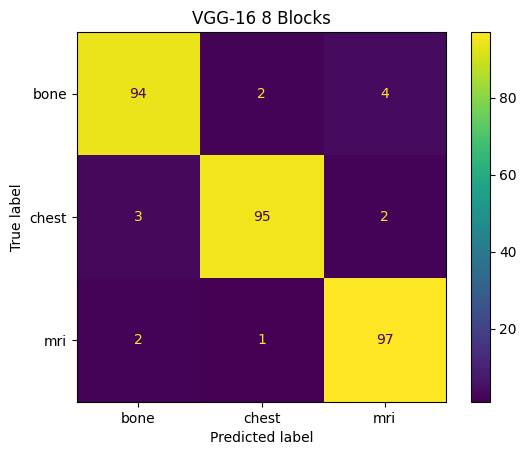

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cf = confusion_matrix(y_true,y_hat)
disp = ConfusionMatrixDisplay(cf,display_labels=np.array(test_data.classes))
disp.plot()
plt.title("VGG-16 8 Blocks")
plt.savefig("VGG-16 8 blocks conf-mat.svg",format="svg")
plt.show()

In [ ]:
try:
    from torchinfo import summary
except ModuleNotFoundError:
    !pip install torchinfo --quiet
    from torchinfo import summary


In [ ]:
summary(model,(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 3]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

## Section 2 Quantization

### 2.1 Static Quantization

In [ ]:
# import torch
# import onnx
# import tensorrt as trt
# import numpy as np
# import pycuda.driver as cuda
# import pycuda.autoinit
# import onnx_tensorrt.backend as backend
# # Export the PyTorch model to ONNX
# dummy_input = torch.randn(1, 3, 224, 224).to(device)
# onnx_filename = 'vgg_quant.onnx'
# torch.onnx.export(model, dummy_input, onnx_filename)
# # Load the ONNX model
# model_onnx = onnx.load(onnx_filename)

# # Create a TensorRT builder and network
# builder = trt.Builder(trt.Logger(trt.Logger.WARNING))
# network = builder.create_network()

# # Create an ONNX-TensorRT backend
# parser = trt.OnnxParser(network, builder.logger)
# parser.parse(model_onnx.SerializeToString())

# # Set up optimization profile and builder parameters
# profile = builder.create_optimization_profile()
# profile.set_shape("input", (1, 3, 224, 224), (1, 3, 224, 224), (1, 3, 224, 224))
# builder_config.set_memory_pool_limit(1 << 30)  # Replace max_workspace_size
# engine = builder.build_serialized_network(network, builder_config)  # Replace build_engine
# builder_config.flags = 1 << int(trt.BuilderFlag.STRICT_TYPES)

# # Build the TensorRT engine from the optimized network
# engine = builder.build_engine(network, builder_config)

# # Allocate device memory for input and output buffers
# input_name = 'input'
# output_name = 'output'
# input_shape = (1, 3, 224, 224)
# output_shape = (1, 3)
# input_buf = trt.cuda.alloc_buffer(builder.max_batch_size * trt.volume(input_shape) * trt.float32.itemsize)
# output_buf = trt.cuda.alloc_buffer(builder.max_batch_size * trt.volume(output_shape) * trt.float32.itemsize)
# # Create a TensorRT execution context
# context = engine.create_execution_context()

# # Run inference on the TensorRT engine
# input_data = torch.randn(1, 3, 224, 224).numpy()
# output_data = np.empty(output_shape, dtype=np.float32)
# input_buf.host = input_data.ravel()
# trt_outputs = [output_buf.device]
# trt_inputs = [input_buf.device]
# context.execute_async_v2(bindings=trt_inputs + trt_outputs, stream_handle=trt.cuda.Stream())
# output_buf.device_to_host()
# output_data[:] = np.reshape(output_buf.host, output_shape)

# # Print the output
# print(output_data)

In [7]:
import torch
import torch.nn.functional as F
import copy

params = ['head.fc.weight', 'head.fc.bias']

def calculate_kl_divergence_scale(param_tensor):
    # Assuming Gaussian distributions for simplicity
    original_distribution = torch.distributions.Normal(torch.mean(param_tensor), torch.std(param_tensor))
    quantized_distribution = torch.distributions.Normal(0, 1.0)  # Assuming a standard normal distribution

    # Generate samples from the original and quantized distributions
    original_samples = original_distribution.sample((param_tensor.numel(),))
    quantized_samples = quantized_distribution.sample((param_tensor.numel(),))

    # Calculate KL divergence
    kl_divergence = F.kl_div(F.log_softmax(original_samples, dim=0), F.softmax(quantized_samples, dim=0), reduction='batchmean')

    # Convert KL divergence to a scale factor
    kl_divergence_scale = torch.exp(-kl_divergence)

    return kl_divergence_scale

quantization_scales = {"kl": [], "max": [], "99%": []}

for param_tensor in params:
    max_scale = torch.max(torch.abs(checkpoint["model_state_dict"][param_tensor]))
    percentile_99_scale = torch.quantile(torch.abs(checkpoint["model_state_dict"][param_tensor]), 0.99)

    # Calculate KL divergence-based scale
    kl_divergence_scale = calculate_kl_divergence_scale(checkpoint["model_state_dict"][param_tensor])
    quantization_scales["kl"].append(kl_divergence_scale.item())
    quantization_scales["max"].append(max_scale.item())
    quantization_scales["99%"].append(percentile_99_scale.item())


#### 2.1.1 KL

In [8]:
import copy
kl_params = copy.deepcopy(checkpoint["model_state_dict"])
for i,param_tensor in enumerate(params ):


    s = (2**8-1)/(quantization_scales["kl"][i])
    quantized_param = kl_params[param_tensor]*s
    quantized_param = torch.clip(quantized_param,min=-s,max=s)
    kl_params[param_tensor].data = quantized_param.data

model.load_state_dict(kl_params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
y_true = []
y_hat = []
start_time  = datetime.datetime.now()
with torch.inference_mode():
    for X,y in tqdm(data_loader):
        X,y=X.to(device),y.to(device)
        y_logits = model(X).softmax(axis=1)
        y_preds = y_logits.argmax(axis=1)
        y_true.append(y)
        y_hat.append(y_preds)
    y_true=torch.cat(y_true,0)
    y_hat=torch.cat(y_hat,0)
end_time = datetime.datetime.now() - start_time
end_time = end_time.total_seconds()
if end_time>3600:
    print(f"Time it took for execution {end_time/3600} hours")
elif end_time>60:
    print(f"Time it took for execution {end_time/60} minutes")
else:
    print(f"Time it took for execution {end_time} seconds ")


if y_true.device != "cpu":
    y_true = y_true.cpu().numpy()
    y_hat = y_hat.cpu().numpy()
else:
    y_true = y_true.numpy()
    y_hat = y_hat.numpy()


print(classification_report(y_true,y_hat))

  0%|          | 0/10 [00:00<?, ?it/s]

Time it took for execution 3.8836256000000002 minutes
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       100
           1       0.97      0.91      0.94       100
           2       0.90      0.95      0.93       100

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



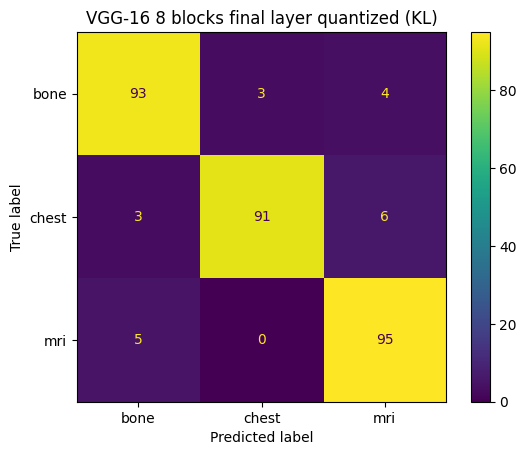

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cf = confusion_matrix(y_true,y_hat)
disp = ConfusionMatrixDisplay(cf,display_labels=np.array(test_data.classes))
disp.plot()
plt.title("VGG-16 8 blocks final layer quantized (KL)")
plt.savefig("VGG-16 8 blocks final layer quantized (KL) conf-mat.svg",format="svg")
plt.show()

#### 2.1.2 Max

In [10]:
import copy
max_params = copy.deepcopy(checkpoint["model_state_dict"])
for i,param_tensor in enumerate(params ):


    s = (2**8-1)/(quantization_scales["max"][i])
    quantized_param = max_params[param_tensor]*s
    quantized_param = torch.clip(quantized_param,min=-s,max=s)
    max_params[param_tensor].data = quantized_param.data

model.load_state_dict(max_params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
y_true = []
y_hat = []
start_time  = datetime.datetime.now()
with torch.inference_mode():
    for X,y in tqdm(data_loader):
        X,y=X.to(device),y.to(device)
        y_logits = model(X).softmax(axis=1)
        y_preds = y_logits.argmax(axis=1)
        y_true.append(y)
        y_hat.append(y_preds)
    y_true=torch.cat(y_true,0)
    y_hat=torch.cat(y_hat,0)
end_time = datetime.datetime.now() - start_time
end_time = end_time.total_seconds()
if end_time>3600:
    print(f"Time it took for execution {end_time/3600} hours")
elif end_time>60:
    print(f"Time it took for execution {end_time/60} minutes")
else:
    print(f"Time it took for execution {end_time} seconds ")


if y_true.device != "cpu":
    y_true = y_true.cpu().numpy()
    y_hat = y_hat.cpu().numpy()
else:
    y_true = y_true.numpy()
    y_hat = y_hat.numpy()


print(classification_report(y_true,y_hat))

  0%|          | 0/10 [00:00<?, ?it/s]

Time it took for execution 3.9591307999999996 minutes
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       100
           1       0.96      0.93      0.94       100
           2       0.92      0.96      0.94       100

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



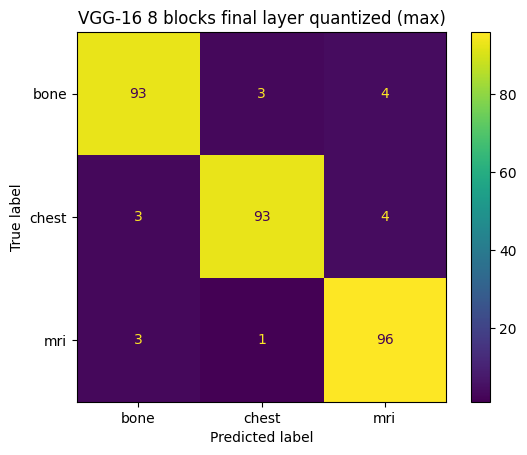

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cf = confusion_matrix(y_true,y_hat)
disp = ConfusionMatrixDisplay(cf,display_labels=np.array(test_data.classes))
disp.plot()
plt.title("VGG-16 8 blocks final layer quantized (max)")
plt.savefig("VGG-16 8 blocks final layer quantized (max) conf-mat.svg",format="svg")

plt.show()

#### 2.1.3 99th  

In [12]:
import copy
percentile_params = copy.deepcopy(checkpoint["model_state_dict"])
for i,param_tensor in enumerate(params ):


    s = (2**8-1)/(quantization_scales["99%"][i])
    quantized_param = percentile_params[param_tensor]*s
    quantized_param = torch.clip(quantized_param,min=-s,max=s)
    percentile_params[param_tensor].data = quantized_param.data

model.load_state_dict(percentile_params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
y_true = []
y_hat = []
start_time  = datetime.datetime.now()
with torch.inference_mode():
    for X,y in tqdm(data_loader):
        X,y=X.to(device),y.to(device)
        y_logits = model(X).softmax(axis=1)
        y_preds = y_logits.argmax(axis=1)
        y_true.append(y)
        y_hat.append(y_preds)
    y_true=torch.cat(y_true,0)
    y_hat=torch.cat(y_hat,0)
end_time = datetime.datetime.now() - start_time
end_time = end_time.total_seconds()
if end_time>3600:
    print(f"Time it took for execution {end_time/3600} hours")
elif end_time>60:
    print(f"Time it took for execution {end_time/60} minutes")
else:
    print(f"Time it took for execution {end_time} seconds ")


if y_true.device != "cpu":
    y_true = y_true.cpu().numpy()
    y_hat = y_hat.cpu().numpy()
else:
    y_true = y_true.numpy()
    y_hat = y_hat.numpy()


print(classification_report(y_true,y_hat))

  0%|          | 0/10 [00:00<?, ?it/s]

Time it took for execution 3.899961983333333 minutes
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       100
           1       0.97      0.93      0.95       100
           2       0.93      0.95      0.94       100

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



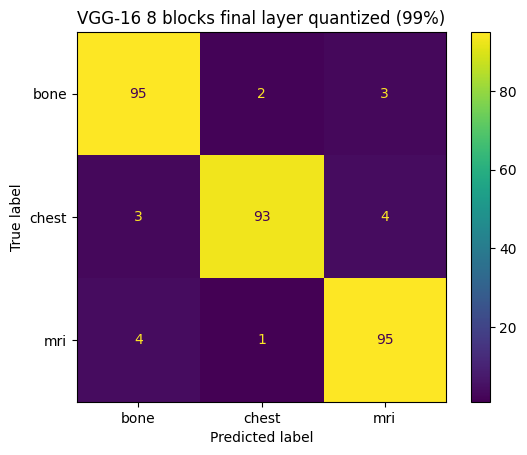

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cf = confusion_matrix(y_true,y_hat)
disp = ConfusionMatrixDisplay(cf,display_labels=np.array(test_data.classes))
disp.plot()
plt.title("VGG-16 8 blocks final layer quantized (99%)")
plt.savefig("VGG-16 8 blocks final layer quantized (99%) conf-mat.svg",format="svg")

plt.show()

In [14]:
import torch

params = checkpoint["model_state_dict"].keys()
quantization_scales = {}

for param_tensor in params:
    tensor = checkpoint["model_state_dict"][param_tensor]
    print(tensor.shape)

    # Randomly shuffle indices and select a subset of the tensor
    sample_size = min(1000, tensor.numel())  # Adjust the sample size as needed
    indices = torch.randperm(tensor.numel())[:sample_size]
    sampled_tensor = tensor.view(-1)[indices]

    # Calculate the 99th percentile from the sampled tensor
    percentile_99_scale = torch.quantile(torch.abs(sampled_tensor), 0.99)

    quantization_scales[param_tensor] = percentile_99_scale


torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([4096, 512, 7, 7])
torch.Size([4096])
torch.Size([4096, 4096, 1, 1])
torch.Size([4096])
torch.Size([3, 4096])
torch.Size([3])


In [15]:
quantization_scales['features.0.weight']

tensor(0.7839)

In [16]:
import copy
percentile_params = copy.deepcopy(checkpoint["model_state_dict"])

for param_tensor in quantization_scales.keys():
    s = (2**8-1)/(quantization_scales[param_tensor].item())
    quantized_param = percentile_params[param_tensor]*s
    quantized_param = torch.clip(quantized_param,min=-s,max=s)
    percentile_params[param_tensor].data = quantized_param.data

model.load_state_dict(percentile_params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
y_true = []
y_hat = []
start_time  = datetime.datetime.now()
with torch.inference_mode():
    for X,y in tqdm(data_loader):
        X,y=X.to(device),y.to(device)
        y_logits = model(X).softmax(axis=1)
        y_preds = y_logits.argmax(axis=1)
        y_true.append(y)
        y_hat.append(y_preds)
    y_true=torch.cat(y_true,0)
    y_hat=torch.cat(y_hat,0)
end_time = datetime.datetime.now() - start_time
end_time = end_time.total_seconds()
if end_time>3600:
    print(f"Time it took for execution {end_time/3600} hours")
elif end_time>60:
    print(f"Time it took for execution {end_time/60} minutes")
else:
    print(f"Time it took for execution {end_time} seconds ")


if y_true.device != "cpu":
    y_true = y_true.cpu().numpy()
    y_hat = y_hat.cpu().numpy()
else:
    y_true = y_true.numpy()
    y_hat = y_hat.numpy()


print(classification_report(y_true,y_hat))

  0%|          | 0/10 [00:00<?, ?it/s]

Time it took for execution 3.849662933333333 minutes
              precision    recall  f1-score   support

           0       0.25      0.02      0.04       100
           1       0.00      0.00      0.00       100
           2       0.33      0.96      0.49       100

    accuracy                           0.33       300
   macro avg       0.19      0.33      0.18       300
weighted avg       0.19      0.33      0.18       300



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


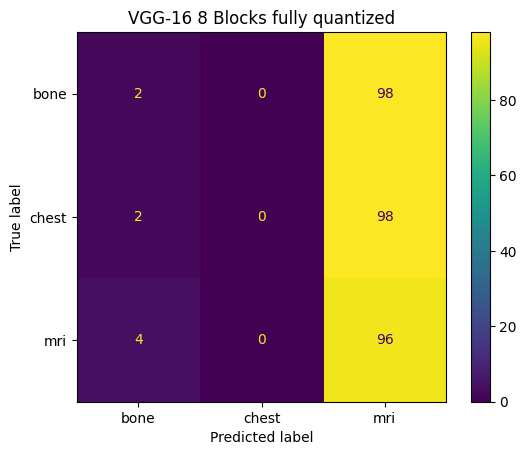

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cf = confusion_matrix(y_true,y_hat)
disp = ConfusionMatrixDisplay(cf,display_labels=np.array(test_data.classes))
disp.plot()
plt.title("VGG-16 8 Blocks fully quantized")
plt.savefig("VGG-16 8 Blocks fully quantized conf-mat.svg",format="svg")

plt.show()